In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn import preprocessing


import os

# Load and Visualize the data

In [2]:
df = pd.read_csv("./Data/heart.csv")
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


1    165
0    138
Name: target, dtype: int64


<function matplotlib.pyplot.show(close=None, block=None)>

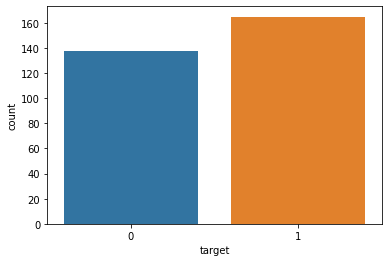

In [3]:
print(df.target.value_counts())
sns.countplot(x='target', data=df)
plt.show

## Split the data into train and test sets

In [4]:
train, test = train_test_split(df, test_size=0.2)

print(f'{len(train)} entries in training set')
print(f'{len(test)} entries in testing set')

X_train = train.drop('target', axis=1)  #creates a new dataframe, does not actually modify df
Y_train = train['target']

X_test = test.drop('target', axis=1)
Y_test = test['target']

train.head()

242 entries in training set
61 entries in testing set


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
91,57,1,0,132,207,0,1,168,1,0.0,2,0,3,1
128,52,0,2,136,196,0,0,169,0,0.1,1,0,2,1
225,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
136,60,0,2,120,178,1,1,96,0,0.0,2,0,2,1
242,64,1,0,145,212,0,0,132,0,2.0,1,2,1,0


# Decision Tree

In [5]:
from sklearn import tree


decision_tree = tree.DecisionTreeClassifier()
decision_tree.fit(X_train, Y_train)

decision_tree_score = decision_tree.score(X_test, Y_test)

In [6]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

Y_pred = decision_tree.predict(X_test)

print(confusion_matrix(Y_test, Y_pred))
print(classification_report(Y_test, Y_pred))
print(accuracy_score(Y_test, Y_pred))

[[19  7]
 [ 7 28]]
              precision    recall  f1-score   support

           0       0.73      0.73      0.73        26
           1       0.80      0.80      0.80        35

    accuracy                           0.77        61
   macro avg       0.77      0.77      0.77        61
weighted avg       0.77      0.77      0.77        61

0.7704918032786885


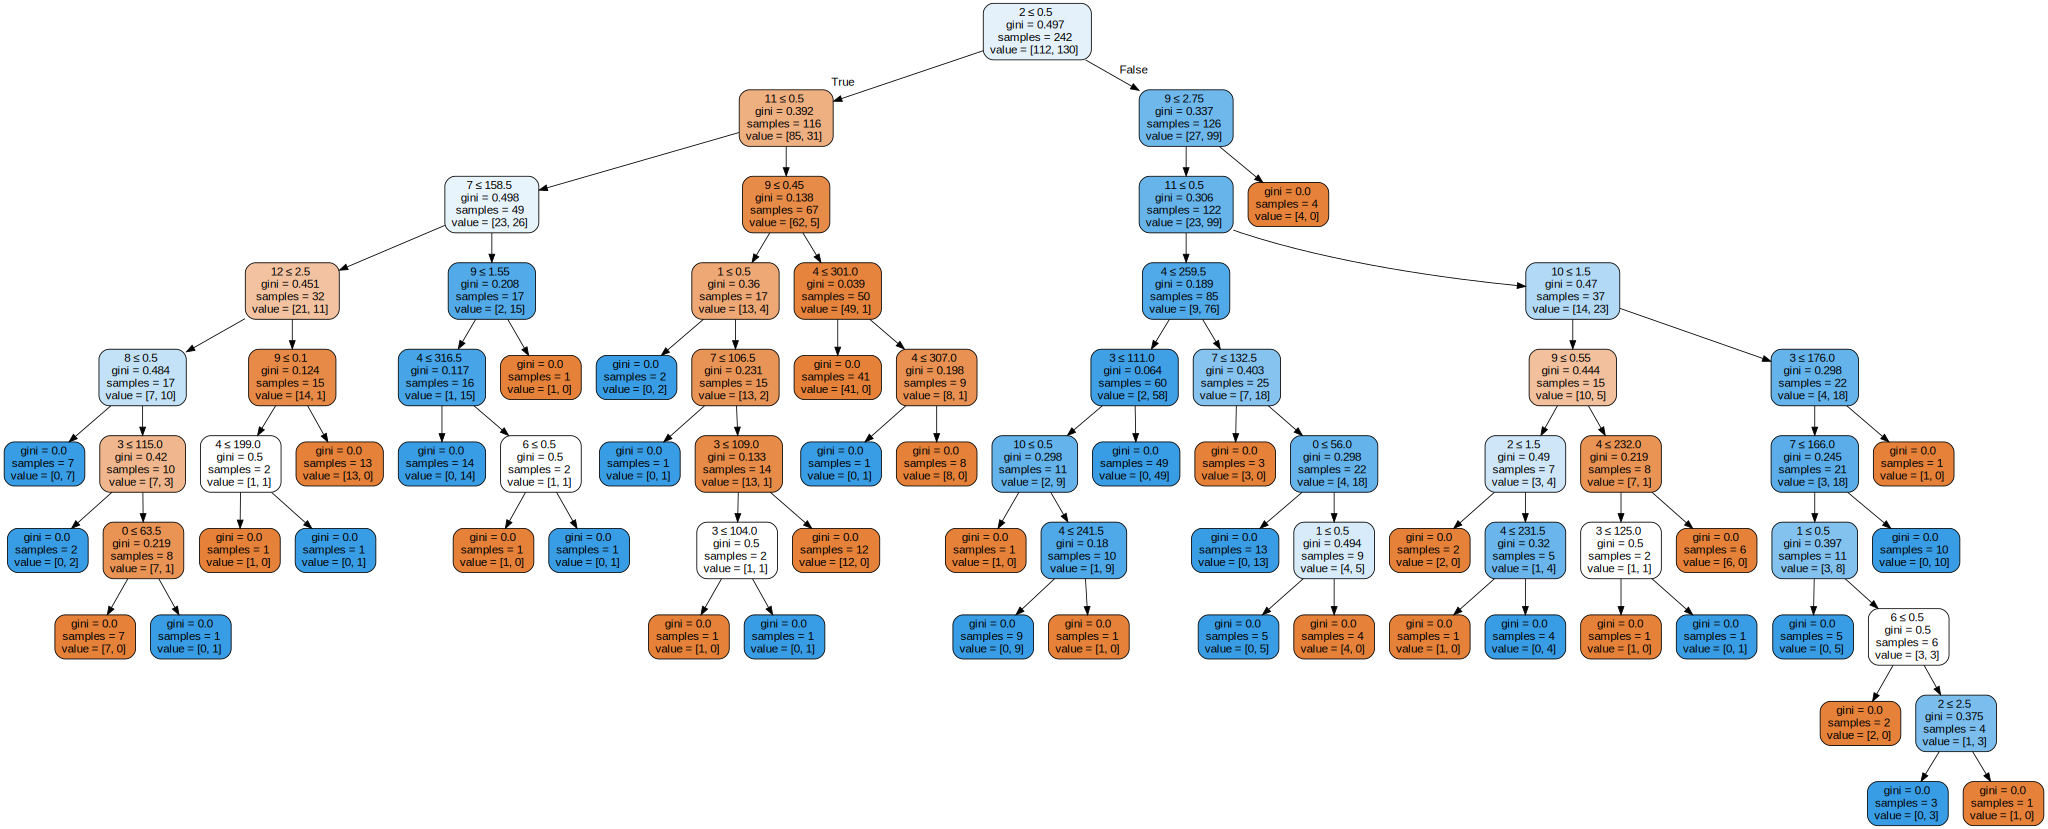

In [18]:
import graphviz

dot_data = tree.export_graphviz(decision_tree, out_file=None, 
                     feature_names=X_test.columns,  
                     #class_names=['True', 'False'],  
                     filled=True, rounded=True,  
                     special_characters=True)  
graph = graphviz.Source(dot_data)  
graph 

# Random Forest

In [8]:
from sklearn.ensemble import RandomForestClassifier

random_forest = RandomForestClassifier(n_estimators=10, random_state=0)
random_forest.fit(X_train, Y_train)

random_forest_score = random_forest.score(X_test, Y_test)

In [9]:
Y_pred = random_forest.predict(X_test)

print(confusion_matrix(Y_test, Y_pred))
print(classification_report(Y_test, Y_pred))
print(accuracy_score(Y_test, Y_pred))


[[22  4]
 [ 8 27]]
              precision    recall  f1-score   support

           0       0.73      0.85      0.79        26
           1       0.87      0.77      0.82        35

    accuracy                           0.80        61
   macro avg       0.80      0.81      0.80        61
weighted avg       0.81      0.80      0.80        61

0.8032786885245902


# Naive Bayes

In [10]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()

gnb.fit(X_train, Y_train)

naive_bayes_score = gnb.score(X_test, Y_test)

In [11]:
Y_pred = gnb.predict(X_test)

print(confusion_matrix(Y_test, Y_pred))
print(classification_report(Y_test, Y_pred))
print(accuracy_score(Y_test, Y_pred))

[[19  7]
 [ 5 30]]
              precision    recall  f1-score   support

           0       0.79      0.73      0.76        26
           1       0.81      0.86      0.83        35

    accuracy                           0.80        61
   macro avg       0.80      0.79      0.80        61
weighted avg       0.80      0.80      0.80        61

0.8032786885245902


# Support Vector Machine

In [12]:
def normalize(x):
    x = x.values

    min_max_scalar = preprocessing.MinMaxScaler()
    x_scaled = min_max_scalar.fit_transform(x)

    df = pd.DataFrame(x_scaled)
    return df

In [13]:
from sklearn import svm

X_test = normalize(X_test)
X_train = normalize(X_train)

clf = svm.SVC()

clf.fit(X_train, Y_train)

svm_score = clf.score(X_test, Y_test)

In [14]:
Y_pred = clf.predict(X_test)

print(confusion_matrix(Y_test, Y_pred))
print(classification_report(Y_test, Y_pred))
print(accuracy_score(Y_test, Y_pred))

[[18  8]
 [ 4 31]]
              precision    recall  f1-score   support

           0       0.82      0.69      0.75        26
           1       0.79      0.89      0.84        35

    accuracy                           0.80        61
   macro avg       0.81      0.79      0.79        61
weighted avg       0.80      0.80      0.80        61

0.8032786885245902


# Neural Network

In [15]:
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(solver='adam', alpha=1e-7, random_state=1, max_iter=500)

clf.fit(X_train, Y_train)

mlp_score = clf.score(X_test, Y_test)

c:\Users\knots\Desktop\MachineLearning\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


In [16]:
Y_pred = clf.predict(X_test)

print(confusion_matrix(Y_test, Y_pred))
print(classification_report(Y_test, Y_pred))
print(accuracy_score(Y_test, Y_pred))

[[20  6]
 [ 5 30]]
              precision    recall  f1-score   support

           0       0.80      0.77      0.78        26
           1       0.83      0.86      0.85        35

    accuracy                           0.82        61
   macro avg       0.82      0.81      0.81        61
weighted avg       0.82      0.82      0.82        61

0.819672131147541


# Comparison of the different models

<AxesSubplot:>

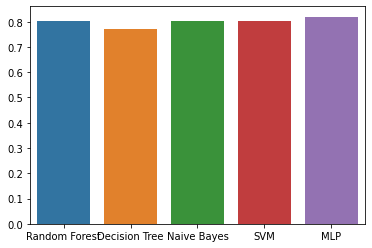

In [17]:
classifiers = ['Random Forest', 'Decision Tree', 'Naive Bayes', 'SVM', 'MLP']
scores = [random_forest_score, decision_tree_score, naive_bayes_score, svm_score, mlp_score]

sns.barplot(y=scores, x=classifiers)